# Assessing forecast performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rcpy.analysis import compute_skill

# 1. Generate synthetic ENSO-like time series
def generate_ground_truth(length=500, seed=42):
    np.random.seed(seed)
    t = np.linspace(0, 20 * np.pi, length)
    base_signal = np.sin(t / 2.5)  # ENSO-like periodicity ~ 2-7 years
    noise = 0.15 * np.random.randn(length)
    return base_signal + noise

# 2. Forecast variants
def generate_forecasts(truth, seed=42):
    np.random.seed(seed)
    length = len(truth)
    noise = np.random.randn(length)

    forecasts = {
        "perfect_forecast": truth,
        "good_forecast": truth + 0.075 * noise,
        "low_amplitude": 0.3 * truth + 0.1 * noise,
        "phase_shift": np.roll(truth, 20),
        "chaotic_drift": np.concatenate([
            truth[:int(0.25 * length)] + 0.01 * noise[:int(0.25 * length)],
            truth[int(0.25 * length):] + 0.1 * np.cumsum(noise[int(0.25 * length):])
        ])
    }
    return forecasts

## Producing forecasts

In [2]:
seed = 82646

truth = generate_ground_truth(length=100, seed=seed)
forecasts = generate_forecasts(truth=truth, seed=seed+1)

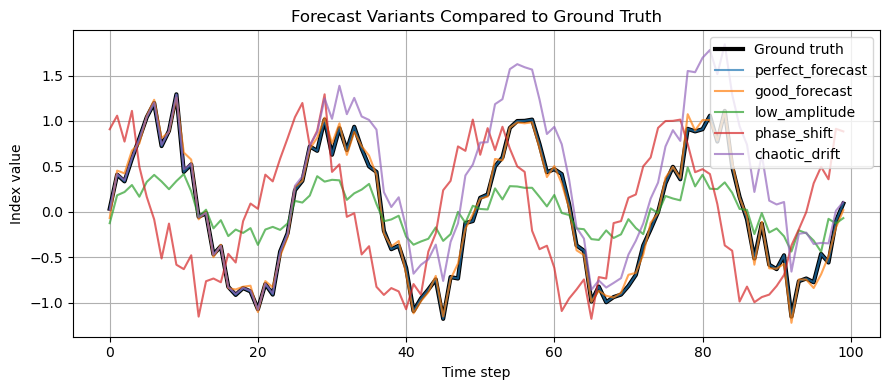

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(truth, label="Ground truth", linewidth=3, color='black')
for name, forecast in forecasts.items():
    plt.plot(forecast, label=name, alpha=0.7)
plt.legend()
plt.title("Forecast Variants Compared to Ground Truth")
plt.xlabel("Time step")
plt.ylabel("Index value")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../results/plots/forecast_variants.png", dpi=200)
#plt.savefig("../../../../Pictures/forecast_variants.png", dpi=200)
plt.show()



## Computing skill

In [4]:
from rcpy.analysis import compute_skill
import pandas as pd

y_true = truth.reshape(-1, 1)
climatology = np.mean(y_true)
climatology = np.full(len(y_true), climatology.item())

skills = {}
for forecast_name, forecast_values in forecasts.items():
    skill_error = compute_skill(truth, forecast_values, method="error", metric="rmse")
    skill_ref = compute_skill(truth, forecast_values, method="reference", reference=climatology, metric="rmse")
    skill_corr = compute_skill(truth, forecast_values, method="pearson")
    skill_efh = compute_skill(truth, forecast_values, method="efh", metric="rmse", threshold=0.25, softness=0.025)
    skills[forecast_name] = {
        "error_rmse": skill_error,
        "reference_rmse": skill_ref,
        "pearson_r": skill_corr,
        "efh_rmse": skill_efh
    }
    print(f"{forecast_name}: error_rmse={skill_error:.3f}, reference_rmse={skill_ref:.3f}, pearson_r={skill_corr:.3f}, efh_rmse={skill_efh:.3f}")


perfect_forecast: error_rmse=0.000, reference_rmse=1.000, pearson_r=1.000, efh_rmse=99.771
good_forecast: error_rmse=0.066, reference_rmse=0.905, pearson_r=0.996, efh_rmse=77.704
low_amplitude: error_rmse=0.485, reference_rmse=0.303, pearson_r=0.929, efh_rmse=2.487
phase_shift: error_rmse=0.824, reference_rmse=-0.185, pearson_r=0.298, efh_rmse=0.000
chaotic_drift: error_rmse=0.420, reference_rmse=0.396, pearson_r=0.943, efh_rmse=29.424


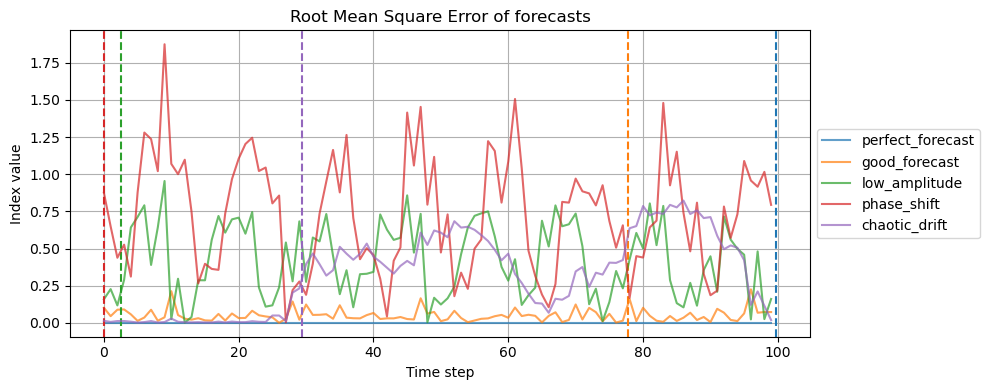

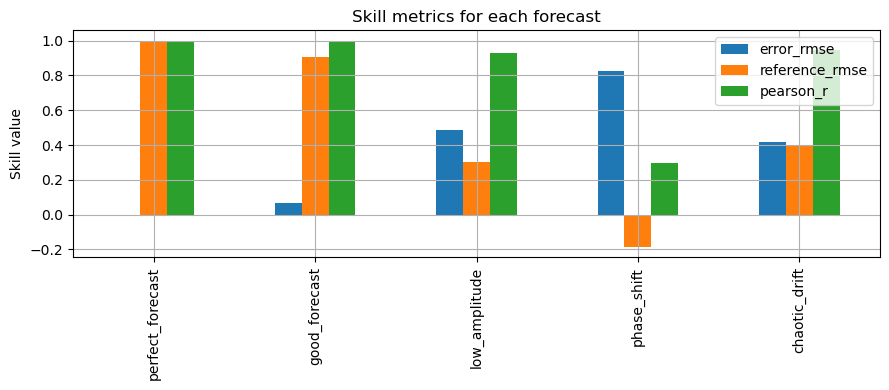

In [ ]:
import matplotlib.pyplot as plt

colors = plt.cm.tab10.colors  # Cycle through 10 distinct colors
# Plot RMSE over time for each forecast, cycling colors
plt.figure(figsize=(10, 4))
for i, (name, forecast) in enumerate(forecasts.items()):
    color = colors[i]
    rmse = compute_skill(truth, forecast, method="error", aggregate=False)
    plt.plot(rmse, label=name, alpha=0.7, color=color)
    plt.axvline(x=skills[name]['efh_rmse'], linestyle='--', color=color)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Root Mean Square Error of forecasts")
plt.xlabel("Time step")
plt.ylabel("Index value")
plt.grid(True)
plt.tight_layout()
plt.savefig("../../../../Pictures/rmse_forecasts.png", dpi=200)
plt.show()


# Plot skills (omit efh_rmse)
skills_df = pd.DataFrame(skills).T.drop(columns=['efh_rmse'])
skills_df.plot(kind='bar', figsize=(9, 4))
plt.title("Skill metrics for each forecast")
plt.ylabel("Skill value")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../../../../Pictures/skill_metrics.png", dpi=200)

plt.show()